In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
import xgboost
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import seaborn as sns
import operator 
plt.style.use('ggplot')
%matplotlib inline 

Import the data (make sure you update this on a daily basis)

In [2]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
latest_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/05-16-2020.csv')
us_medical_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/05-16-2020.csv')

In [3]:
latest_data.head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key
0,45001.0,Abbeville,South Carolina,US,2020-05-17 02:32:32,34.223334,-82.461707,34,0,0,34,"Abbeville, South Carolina, US"
1,22001.0,Acadia,Louisiana,US,2020-05-17 02:32:32,30.295065,-92.414197,192,11,0,181,"Acadia, Louisiana, US"
2,51001.0,Accomack,Virginia,US,2020-05-17 02:32:32,37.767072,-75.632346,668,9,0,659,"Accomack, Virginia, US"
3,16001.0,Ada,Idaho,US,2020-05-17 02:32:32,43.452658,-116.241552,773,22,0,751,"Ada, Idaho, US"
4,19001.0,Adair,Iowa,US,2020-05-17 02:32:32,41.330756,-94.471059,4,0,0,4,"Adair, Iowa, US"


In [4]:
latest_data.to_csv('us.csv')

In [5]:
confirmed_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,4033,4402,4687,4963,5226,5639,6053,6402,6664,7072
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,856,868,872,876,880,898,916,933,946,948
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,5558,5723,5891,6067,6253,6442,6629,6821,7019,7201
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,754,755,755,758,760,761,761,761,761,761
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,43,45,45,45,45,48,48,48,48,50


In [6]:
us_medical_data.head()

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,Alabama,US,2020-05-17 02:32:37,32.3182,-86.9023,11674,485,NaN,11189.0,1,238.090139,153494.0,1387.0,4.154531,84000001,USA,3130.495790,11.881103
1,Alaska,US,2020-05-17 02:32:37,61.3707,-152.4044,388,10,344.0,34.0,2,53.038432,33281.0,NaN,2.577320,84000002,USA,4549.412545,NaN
2,American Samoa,US,2020-05-17 02:32:37,-14.2710,-170.1320,0,0,NaN,0.0,60,0.000000,105.0,NaN,NaN,16,ASM,188.709764,NaN
3,Arizona,US,2020-05-17 02:32:37,33.7298,-111.4312,13666,679,3357.0,9630.0,4,187.752869,146788.0,1683.0,4.968535,84000004,USA,2016.674092,12.315235
4,Arkansas,US,2020-05-17 02:32:37,34.9697,-92.3731,4578,98,3472.0,1008.0,5,151.699713,81644.0,520.0,2.140673,84000005,USA,2705.410954,11.358672


In [7]:
cols = confirmed_df.keys()


### Get outbreak numbers for each day since 1/22/20

In [8]:
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]

In [9]:
confirmed.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20
0,0,0,0,0,0,0,0,0,0,0,...,4033,4402,4687,4963,5226,5639,6053,6402,6664,7072
1,0,0,0,0,0,0,0,0,0,0,...,856,868,872,876,880,898,916,933,946,948
2,0,0,0,0,0,0,0,0,0,0,...,5558,5723,5891,6067,6253,6442,6629,6821,7019,7201
3,0,0,0,0,0,0,0,0,0,0,...,754,755,755,758,760,761,761,761,761,761
4,0,0,0,0,0,0,0,0,0,0,...,43,45,45,45,45,48,48,48,48,50


Getting daily increases

In [10]:
countries=['china','italy','us','spain','france','germany','uk','russia','brazil']
g = globals()
def init_lists(string):
    ''' initialize the name of lists for each country for 
    confirmed, death, and recovery cases'''
    
    
    for i in countries:
        g['{0}_{1}'.format(i,string)] = []

In [11]:
dates = confirmed.keys()
world_cases = []
total_deaths = [] 
mortality_rate = []
recovery_rate = [] 
total_recovered = [] 
total_active = [] 

#Initializing all the lists
init_lists('cases')
init_lists('deaths')
init_lists('recoveries')

values=['China','Italy','US','Spain','France','Germany','United Kingdom','Russia','Brazil']

for i in dates:
    confirmed_sum = confirmed[i].sum()
    print(type(confirmed_sum))
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    
    # confirmed, deaths, recovered, and active
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    total_recovered.append(recovered_sum)
    total_active.append(confirmed_sum-death_sum-recovered_sum)
    
    # calculating the mortality and recovery rate
    mortality_rate.append(death_sum/confirmed_sum)
    recovery_rate.append(recovered_sum/confirmed_sum)

    # getting the confirmed, deaths, and recovered, for each country
    for j in range(len(countries)):
        g['{0}_{1}'.format(countries[j],'cases')].append(confirmed_df[confirmed_df['Country/Region']==values[j]][i].sum())
        g['{0}_{1}'.format(countries[j],'deaths')].append(deaths_df[deaths_df['Country/Region']==values[j]][i].sum())
        g['{0}_{1}'.format(countries[j],'recoveries')].append(recoveries_df[recoveries_df['Country/Region']==values[j]][i].sum())

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'nu

In [12]:
def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 

# confirmed cases
world_daily_increase = daily_increase(world_cases)

# deaths
world_daily_death = daily_increase(total_deaths)


# recoveries
world_daily_recovery = daily_increase(total_recovered)


In [13]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)
total_recovered = np.array(total_recovered).reshape(-1, 1)

In [14]:
days_since_1_22

array([[  0],
       [  1],
       [  2],
       [  3],
       [  4],
       [  5],
       [  6],
       [  7],
       [  8],
       [  9],
       [ 10],
       [ 11],
       [ 12],
       [ 13],
       [ 14],
       [ 15],
       [ 16],
       [ 17],
       [ 18],
       [ 19],
       [ 20],
       [ 21],
       [ 22],
       [ 23],
       [ 24],
       [ 25],
       [ 26],
       [ 27],
       [ 28],
       [ 29],
       [ 30],
       [ 31],
       [ 32],
       [ 33],
       [ 34],
       [ 35],
       [ 36],
       [ 37],
       [ 38],
       [ 39],
       [ 40],
       [ 41],
       [ 42],
       [ 43],
       [ 44],
       [ 45],
       [ 46],
       [ 47],
       [ 48],
       [ 49],
       [ 50],
       [ 51],
       [ 52],
       [ 53],
       [ 54],
       [ 55],
       [ 56],
       [ 57],
       [ 58],
       [ 59],
       [ 60],
       [ 61],
       [ 62],
       [ 63],
       [ 64],
       [ 65],
       [ 66],
       [ 67],
       [ 68],
       [ 69],
       [ 70],
      

In [13]:
ls=[world_cases, total_deaths, total_recovered, total_active]
df=pd.DataFrame(ls)
df=df.T
df.columns=['confirmed','death','recovered','active']
df

,confirmed,death,recovered,active
0,555,17,28,510
1,654,18,30,606
2,941,26,36,879
3,1434,42,39,1353
4,2118,56,52,2010
...,...,...,...,...
112,4347018,297197,1548547,2501274
113,4442163,302418,1587893,2551852
114,4542347,307666,1637067,2597614
115,4634068,311781,1693197,2629090


In [14]:
df=df.shift(periods=1, freq=None, axis=0)
df=df.fillna(0)
df['label']=total_active
df['days']=days_since_1_22
df.head()

,confirmed,death,recovered,active,label,days
0,0.0,0.0,0.0,0.0,510,0
1,555.0,17.0,28.0,510.0,606,1
2,654.0,18.0,30.0,606.0,879,2
3,941.0,26.0,36.0,879.0,1353,3
4,1434.0,42.0,39.0,1353.0,2010,4


In [15]:
X_train_confirmed, X_test_confirmed = train_test_split(df, test_size=0.20, shuffle=False) 
X_train_confirmed.head()


,confirmed,death,recovered,active,label,days
0,0.0,0.0,0.0,0.0,510,0
1,555.0,17.0,28.0,510.0,606,1
2,654.0,18.0,30.0,606.0,879,2
3,941.0,26.0,36.0,879.0,1353,3
4,1434.0,42.0,39.0,1353.0,2010,4


In [16]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
data_normalized_train = scalar.fit_transform(X_train_confirmed.iloc[:, :-1])
data_normalized_test=scalar.transform(X_test_confirmed.iloc[:, :-1])
train=np.concatenate((X_train_confirmed.iloc[:, -1 :], data_normalized_train), axis = 1)
test=np.concatenate((X_test_confirmed.iloc[:, -1:], data_normalized_test), axis = 1)


In [17]:

X_train=train[:, :-1]
X_test=test[:, :-1]
y_train=train[:, -1:]
y_test=test[:, -1:]


Model for predicting # of confirmed cases. I am using support vector machine, bayesian ridge , and linear regression in this example. 

In [18]:
# # use this to find the optimal parameters for SVR for polynomial kernal
c = [0.01, 0.1, 1]
gamma = [0.01, 0.1, 1]
epsilon = [0.01, 0.1, 1]
degree = [2,3]
svm_grid = {'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'degree': degree}

svm = SVR(kernel='poly')
svm_poly = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_iter=30, verbose=1)
svm_poly.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A

/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='poly',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=30, n_jobs=None,
                   param_distributions={'C': [0.01, 0.1, 1], 'degree': [2, 3],
                                        'epsilon': [0.01, 0.1, 1],
                                        'gamma': [0.01, 0.1, 1]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [20]:
df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_gamma', 'param_epsilon', 'param_degree', 'param_C', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score',
       'split0_train_score', 'split1_train_score', 'split2_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')

In [22]:
df = pd.DataFrame(svm_poly.cv_results_)
df=df[['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_gamma', 'param_epsilon', 'param_degree', 'param_C', 'params',
       'mean_test_score', 'std_test_score', 'rank_test_score',
       'mean_train_score', 'std_train_score']]
df['mean_test_score'] = -df['mean_test_score']
df['mean_train_score'] = -df['mean_train_score']
df=df.sort_values(by=['mean_test_score'])
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_epsilon,param_degree,param_C,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
2,1.423716,0.752182,0.002751,0.000651,0.01,0.01,3,0.1,"{'gamma': 0.01, 'epsilon': 0.01, 'degree': 3, ...",5.912355e-02,7.855057e-02,1,6.975299e-04,2.143028e-04
17,0.339796,0.126839,0.000476,0.000025,0.1,0.01,2,0.1,"{'gamma': 0.1, 'epsilon': 0.01, 'degree': 2, '...",1.982683e-01,2.720850e-01,2,4.191970e-04,2.055238e-04
3,0.357353,0.104273,0.002886,0.000562,0.1,0.01,2,0.01,"{'gamma': 0.1, 'epsilon': 0.01, 'degree': 2, '...",2.004231e-01,2.747662e-01,3,6.799731e-04,2.383627e-04
18,0.003325,0.001698,0.000380,0.000022,1,0.1,2,1,"{'gamma': 1, 'epsilon': 0.1, 'degree': 2, 'C': 1}",3.187208e-01,4.344356e-01,4,4.022463e-03,1.434699e-04
29,0.004316,0.002355,0.000367,0.000010,0.1,0.1,2,0.1,"{'gamma': 0.1, 'epsilon': 0.1, 'degree': 2, 'C...",3.189151e-01,4.345894e-01,5,4.046604e-03,1.521064e-04
22,0.003110,0.001507,0.000362,0.000008,0.01,0.1,2,1,"{'gamma': 0.01, 'epsilon': 0.1, 'degree': 2, '...",3.193028e-01,4.346846e-01,6,4.183578e-03,2.345285e-04
25,0.010831,0.008710,0.000350,0.000004,0.1,0.1,3,0.1,"{'gamma': 0.1, 'epsilon': 0.1, 'degree': 3, 'C...",4.761405e-01,6.602806e-01,7,3.967242e-03,2.020453e-04
0,0.080437,0.056105,0.003046,0.001122,0.1,0.1,3,0.01,"{'gamma': 0.1, 'epsilon': 0.1, 'degree': 3, 'C...",4.761405e-01,6.602806e-01,7,3.967242e-03,2.020453e-04
21,0.014210,0.010857,0.000359,0.000003,0.01,0.1,3,1,"{'gamma': 0.01, 'epsilon': 0.1, 'degree': 3, '...",4.761623e-01,6.603076e-01,9,3.970207e-03,2.060578e-04
8,0.009820,0.008806,0.000631,0.000108,1,0.1,3,0.1,"{'gamma': 1, 'epsilon': 0.1, 'degree': 3, 'C':...",4.762258e-01,6.602837e-01,10,3.962054e-03,2.225085e-04


In [23]:
svm_poly.best_params_

{'gamma': 0.01, 'epsilon': 0.01, 'degree': 3, 'C': 0.1}

In [55]:
# svm_confirmed = svm_search.best_estimator_
svm_poly = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=0.01, C=0.1,degree=3)
svm_poly.fit(X_train, y_train)
#svm_pred = svm_confirmed.predict(future_forcast)
# check against testing data
svm_poly_test_pred = svm_poly.predict(X_test)
print('MAE for SVR polynomial:', mean_absolute_error(svm_poly_test_pred, y_test))
print('MSE for SVR polynomial:',mean_squared_error(svm_poly_test_pred, y_test))
print('R2 value for SVR polynomial:',svm_poly.score(X_test,y_test))

/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAE for SVR polynomial: 0.745242529416684
MSE for SVR polynomial: 0.8307635801242211
R2 value for SVR polynomial: -2.678865603964642


In [26]:
# # use this to find the optimal parameters for SVR for linear
c = [0.01, 0.1, 1]
gamma = [0.01, 0.1, 1]
epsilon = [0.01, 0.1, 1]
shrinking = [True, False]
svm_grid = {'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking}

svm = SVR(kernel='linear')
svm_linear = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=30, verbose=1)
svm_linear.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.9s finished
/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='linear',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=30, n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 1],
                                        'epsilon': [0.01, 0.1, 1],
                                        'gamma': [0.01, 0.1, 1],
                                        'shrinking': [True, False]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [27]:
df = pd.DataFrame(svm_linear.cv_results_)
df=df[['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_shrinking', 'param_gamma', 'param_epsilon', 'param_C', 'params',
       'mean_test_score', 'std_test_score', 'rank_test_score',
       'mean_train_score', 'std_train_score']]
df['mean_test_score'] = -df['mean_test_score']
df['mean_train_score'] = -df['mean_train_score']
df=df.sort_values(by=['mean_test_score'])
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_shrinking,param_gamma,param_epsilon,param_C,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
3,0.140331,0.067674,0.000623,0.000016,True,0.1,0.01,1,"{'shrinking': True, 'gamma': 0.1, 'epsilon': 0...",0.100416,0.137798,1,0.000167,0.000075
12,0.164290,0.067331,0.000697,0.000112,True,1,0.01,1,"{'shrinking': True, 'gamma': 1, 'epsilon': 0.0...",0.100416,0.137798,1,0.000167,0.000075
21,0.311420,0.141509,0.000405,0.000063,False,0.1,0.01,1,"{'shrinking': False, 'gamma': 0.1, 'epsilon': ...",0.101290,0.139109,3,0.000166,0.000074
20,0.005882,0.002941,0.000501,0.000027,True,0.1,0.1,1,"{'shrinking': True, 'gamma': 0.1, 'epsilon': 0...",0.254362,0.301698,4,0.004198,0.000333
18,0.021328,0.008611,0.000565,0.000015,False,0.1,0.1,1,"{'shrinking': False, 'gamma': 0.1, 'epsilon': ...",0.254419,0.301654,5,0.004203,0.000317
15,0.021958,0.007423,0.000781,0.000286,False,1,0.1,1,"{'shrinking': False, 'gamma': 1, 'epsilon': 0....",0.254419,0.301654,5,0.004203,0.000317
16,0.045846,0.022977,0.000614,0.000034,False,0.01,0.01,0.1,"{'shrinking': False, 'gamma': 0.01, 'epsilon':...",0.502168,0.684704,7,0.001398,0.000711
4,0.045484,0.023989,0.000575,0.000018,False,0.1,0.01,0.1,"{'shrinking': False, 'gamma': 0.1, 'epsilon': ...",0.502168,0.684704,7,0.001398,0.000711
6,0.046545,0.022654,0.001207,0.000843,False,1,0.01,0.1,"{'shrinking': False, 'gamma': 1, 'epsilon': 0....",0.502168,0.684704,7,0.001398,0.000711
13,0.022168,0.001643,0.000605,0.000021,True,1,0.01,0.1,"{'shrinking': True, 'gamma': 1, 'epsilon': 0.0...",0.502475,0.685438,10,0.001394,0.000712


In [28]:
svm_linear.best_params_

{'shrinking': True, 'gamma': 0.1, 'epsilon': 0.01, 'C': 1}

In [54]:
# svm_confirmed = svm_search.best_estimator_
svm_linear = SVR(shrinking=True, kernel='linear',gamma=0.1, epsilon=0.01, C=1)
svm_linear.fit(X_train, y_train)
#svm_pred = svm_confirmed.predict(future_forcast)
# check against testing data
svm_linear_test_pred = svm_linear.predict(X_test)

print('MAE for SVR linear:', mean_absolute_error(svm_linear_test_pred, y_test))
print('MSE for SVR linear:',mean_squared_error(svm_linear_test_pred, y_test))
print('R2 value for SVR linear:',svm_linear.score(X_test,y_test))

/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAE for SVR linear: 0.04514735892900571
MSE for SVR linear: 0.002994608788609921
R2 value for SVR linear: 0.9867389910519427


In [50]:
# # use this to find the optimal parameters for SVR for RBF kernal
c = [0.01, 0.1, 1]
gamma = [0.01, 0.1, 1]
epsilon = [0.01, 0.1, 1]
shrinking = [True, False]
svm_grid = {'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking}

svm = SVR(kernel='rbf')
svm_rbf = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=30, verbose=1)
svm_rbf.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.0s finished
/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=30, n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 1],
                                        'epsilon': [0.01, 0.1, 1],
                                        'gamma': [0.01, 0.1, 1],
                                        'shrinking': [True, False]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [51]:
df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_tol', 'param_normalize', 'param_lambda_2', 'param_lambda_1',
       'param_alpha_2', 'param_alpha_1', 'params', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'mean_train_score',
       'std_train_score'],
      dtype='object')

In [52]:
df = pd.DataFrame(svm_rbf.cv_results_)
df=df[['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_gamma', 'param_epsilon', 'param_C', 'params',
       'mean_test_score', 'std_test_score', 'rank_test_score',
       'mean_train_score', 'std_train_score']]
df['mean_test_score'] = -df['mean_test_score']
df['mean_train_score'] = -df['mean_train_score']
df=df.sort_values(by=['mean_test_score'])
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_epsilon,param_C,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
2,0.000928,0.000103,0.000742,0.000033,0.01,0.1,0.01,"{'shrinking': False, 'gamma': 0.01, 'epsilon':...",1.409161,1.807151,1,0.879639,0.623015
16,0.000925,0.000137,0.000711,0.000045,0.1,0.1,0.01,"{'shrinking': True, 'gamma': 0.1, 'epsilon': 0...",1.426266,1.832962,2,0.989289,0.701092
27,0.000835,0.000161,0.000624,0.000125,1,0.1,0.01,"{'shrinking': True, 'gamma': 1, 'epsilon': 0.1...",1.440817,1.856520,3,1.035977,0.733995
20,0.000903,0.000141,0.000701,0.000049,1,0.1,0.01,"{'shrinking': False, 'gamma': 1, 'epsilon': 0....",1.440817,1.856520,3,1.035977,0.733995
1,0.001241,0.000381,0.000830,0.000082,0.01,0.01,0.01,"{'shrinking': True, 'gamma': 0.01, 'epsilon': ...",1.468575,1.901745,5,0.883772,0.627215
19,0.001080,0.000058,0.000777,0.000034,1,0.01,0.1,"{'shrinking': False, 'gamma': 1, 'epsilon': 0....",1.469735,1.889623,6,0.853263,0.609037
0,0.001643,0.000044,0.000830,0.000022,1,0.01,0.01,"{'shrinking': False, 'gamma': 1, 'epsilon': 0....",1.480504,1.913917,7,1.036495,0.734601
21,0.001011,0.000086,0.000765,0.000026,0.1,0.01,0.01,"{'shrinking': True, 'gamma': 0.1, 'epsilon': 0...",1.484257,1.918197,8,0.990412,0.702797
5,0.001127,0.000264,0.000748,0.000077,0.1,0.1,0.1,"{'shrinking': False, 'gamma': 0.1, 'epsilon': ...",1.490163,1.693035,9,0.444021,0.310526
23,0.000757,0.000109,0.000590,0.000097,0.01,0.1,0.1,"{'shrinking': False, 'gamma': 0.01, 'epsilon':...",1.591093,1.541530,10,0.102051,0.067753


In [53]:
svm_rbf.best_params_

{'shrinking': False, 'gamma': 0.01, 'epsilon': 0.1, 'C': 0.01}

In [56]:
# svm_confirmed = svm_search.best_estimator_
svm_rbf = SVR(shrinking=False, kernel='linear',gamma=0.01, epsilon=0.1, C=0.01)
svm_rbf.fit(X_train, y_train)
#svm_pred = svm_confirmed.predict(future_forcast)
# check against testing data
svm_rbf_test_pred = svm_rbf.predict(X_test)

print('MAE for SVR linear:', mean_absolute_error(svm_rbf_test_pred, y_test))
print('MSE for SVR linear:',mean_squared_error(svm_rbf_test_pred, y_test))
print('R2 value for SVR linear:',svm_linear.score(X_test,y_test))

MAE for SVR linear: 0.43259235009707514
MSE for SVR linear: 0.2393231470876441
R2 value for SVR linear: 0.9867389910519427


/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Bayesian ridge polynomial regression hyperparameter search

In [87]:
bayesian_poly = PolynomialFeatures(degree=2)
bayesian_poly_X_train_confirmed = bayesian_poly.fit_transform(X_train)
bayesian_poly_X_test_confirmed = bayesian_poly.fit_transform(X_test)

# bayesian ridge polynomial regression
tol = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2, 
                 'normalize' : normalize}

bayesian = BayesianRidge(fit_intercept=False)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(bayesian_poly_X_train_confirmed, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.2s finished
/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                                           alpha_init=None, compute_score=False,
                                           copy_X=True, fit_intercept=False,
                                           lambda_1=1e-06, lambda_2=1e-06,
                                           lambda_init=None, n_iter=300,
                                           normalize=False, tol=0.001,
                                           verbose=False),
                   iid='deprecated', n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                  

In [88]:
df = pd.DataFrame(bayesian_search.cv_results_)
df=df[['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_tol', 'param_normalize', 'param_lambda_2', 'param_lambda_1',
       'param_alpha_2', 'param_alpha_1', 'params', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'mean_train_score',
       'std_train_score']]
df['mean_test_score'] = -df['mean_test_score']
df['mean_train_score'] = -df['mean_train_score']
df=df.sort_values(by=['mean_test_score'])
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tol,param_normalize,param_lambda_2,param_lambda_1,param_alpha_2,param_alpha_1,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
25,0.001218,0.000238,0.000318,0.000011,0.0001,False,1e-05,1e-05,0.001,0.001,"{'tol': 0.0001, 'normalize': False, 'lambda_2'...",0.081176,0.073332,1,0.000054,0.000023
22,0.002443,0.000646,0.000540,0.000012,1e-05,True,1e-05,1e-05,0.001,1e-06,"{'tol': 1e-05, 'normalize': True, 'lambda_2': ...",0.081185,0.073345,2,0.000054,0.000023
5,0.002704,0.000577,0.000538,0.000006,1e-05,False,1e-05,0.0001,0.001,1e-05,"{'tol': 1e-05, 'normalize': False, 'lambda_2':...",0.081192,0.073354,3,0.000054,0.000023
6,0.003246,0.002104,0.000659,0.000043,0.001,True,1e-05,1e-07,0.001,1e-06,"{'tol': 0.001, 'normalize': True, 'lambda_2': ...",0.081195,0.073347,4,0.000054,0.000023
21,0.002405,0.000606,0.000538,0.000070,1e-06,False,1e-06,1e-05,0.001,0.001,"{'tol': 1e-06, 'normalize': False, 'lambda_2':...",0.081206,0.073360,5,0.000054,0.000023
26,0.002276,0.000290,0.000576,0.000008,1e-05,False,1e-06,1e-07,0.001,1e-07,"{'tol': 1e-05, 'normalize': False, 'lambda_2':...",0.081216,0.073372,6,0.000054,0.000023
24,0.002195,0.000385,0.000500,0.000091,1e-05,True,1e-06,1e-05,0.001,1e-05,"{'tol': 1e-05, 'normalize': True, 'lambda_2': ...",0.081216,0.073373,7,0.000054,0.000023
13,0.002220,0.000170,0.000550,0.000020,0.001,True,1e-06,1e-06,0.001,0.001,"{'tol': 0.001, 'normalize': True, 'lambda_2': ...",0.081216,0.073362,8,0.000054,0.000023
11,0.002311,0.000635,0.000560,0.000056,1e-05,True,1e-07,1e-07,0.001,0.0001,"{'tol': 1e-05, 'normalize': True, 'lambda_2': ...",0.081218,0.073374,9,0.000054,0.000023
33,0.001679,0.000132,0.000542,0.000012,0.01,True,1e-05,1e-06,0.001,0.0001,"{'tol': 0.01, 'normalize': True, 'lambda_2': 1...",0.081290,0.073359,10,0.000054,0.000023


In [89]:
bayesian_search.best_params_

{'tol': 0.0001,
 'normalize': False,
 'lambda_2': 1e-05,
 'lambda_1': 1e-05,
 'alpha_2': 0.001,
 'alpha_1': 0.001}

In [90]:
bayesian = bayesian_search.best_estimator_
test_bayesian_pred2 = bayesian.predict(bayesian_poly_X_test_confirmed)
print('MAE value for Bayesian Ridge degree 2:', mean_absolute_error(test_bayesian_pred2, y_test))
print('MSE value for Bayesian Ridge degree 2:',mean_squared_error(test_bayesian_pred2, y_test))
print('R2 value for Bayesian Ridge degree 2:',bayesian.score(bayesian_poly_X_test_confirmed,y_test))


MAE value for Bayesian Ridge degree 2: 0.07950167664999984
MSE value for Bayesian Ridge degree 2: 0.007800818233843834
R2 value for Bayesian Ridge degree 2: 0.9654556812914484


In [81]:
bayesian_poly = PolynomialFeatures(degree=3)
bayesian_poly_X_train_confirmed = bayesian_poly.fit_transform(X_train)
bayesian_poly_X_test_confirmed = bayesian_poly.fit_transform(X_test)

# bayesian ridge polynomial regression
tol = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2, 
                 'normalize' : normalize}

bayesian = BayesianRidge(fit_intercept=False)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(bayesian_poly_X_train_confirmed, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.2s finished
/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                                           alpha_init=None, compute_score=False,
                                           copy_X=True, fit_intercept=False,
                                           lambda_1=1e-06, lambda_2=1e-06,
                                           lambda_init=None, n_iter=300,
                                           normalize=False, tol=0.001,
                                           verbose=False),
                   iid='deprecated', n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                  

In [82]:
df = pd.DataFrame(bayesian_search.cv_results_)
df=df[['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_tol', 'param_normalize', 'param_lambda_2', 'param_lambda_1',
       'param_alpha_2', 'param_alpha_1', 'params', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'mean_train_score',
       'std_train_score']]
df['mean_test_score'] = -df['mean_test_score']
df['mean_train_score'] = -df['mean_train_score']
df=df.sort_values(by=['mean_test_score'])
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tol,param_normalize,param_lambda_2,param_lambda_1,param_alpha_2,param_alpha_1,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
14,0.002115,0.000127,0.000583,0.000014,0.01,True,1e-07,0.0001,0.001,0.0001,"{'tol': 0.01, 'normalize': True, 'lambda_2': 1...",513.879234,726.643635,1,0.000039,0.000019
28,0.004062,0.002879,0.000584,0.000052,0.01,True,1e-07,1e-06,0.001,1e-07,"{'tol': 0.01, 'normalize': True, 'lambda_2': 1...",513.882204,726.647835,2,0.000039,0.000019
1,0.002277,0.000534,0.000673,0.000145,0.0001,False,1e-07,1e-05,0.001,0.0001,"{'tol': 0.0001, 'normalize': False, 'lambda_2'...",513.885679,726.652719,3,0.000039,0.000019
0,0.002206,0.000290,0.000537,0.000121,0.0001,False,1e-06,1e-06,0.001,1e-05,"{'tol': 0.0001, 'normalize': False, 'lambda_2'...",513.889928,726.658753,4,0.000039,0.000019
33,0.005416,0.004588,0.000563,0.000008,0.0001,True,1e-05,1e-07,0.001,1e-06,"{'tol': 0.0001, 'normalize': True, 'lambda_2':...",513.938116,726.727144,5,0.000039,0.000019
16,0.002198,0.000046,0.000632,0.000071,0.001,False,0.0001,1e-07,0.001,1e-07,"{'tol': 0.001, 'normalize': False, 'lambda_2':...",514.421651,727.412665,6,0.000038,0.000019
22,0.002343,0.000237,0.000615,0.000038,1e-05,True,0.001,0.0001,0.001,1e-07,"{'tol': 1e-05, 'normalize': True, 'lambda_2': ...",519.190793,734.162361,7,0.000037,0.000018
29,0.002452,0.000236,0.000616,0.000068,1e-05,True,0.001,1e-05,0.001,0.0001,"{'tol': 1e-05, 'normalize': True, 'lambda_2': ...",519.194890,734.168155,8,0.000037,0.000018
12,0.002494,0.000196,0.000850,0.000390,0.001,True,1e-07,1e-05,0.0001,1e-05,"{'tol': 0.001, 'normalize': True, 'lambda_2': ...",721.373645,1020.087187,9,0.000038,0.000019
3,0.004333,0.002912,0.000571,0.000020,0.001,True,1e-07,1e-06,0.0001,1e-07,"{'tol': 0.001, 'normalize': True, 'lambda_2': ...",721.374229,1020.088013,10,0.000038,0.000019


In [83]:
bayesian_search.best_params_

{'tol': 0.01,
 'normalize': True,
 'lambda_2': 1e-07,
 'lambda_1': 0.0001,
 'alpha_2': 0.001,
 'alpha_1': 0.0001}

In [85]:
bayesian = bayesian_search.best_estimator_
test_bayesian_pred3 = bayesian.predict(bayesian_poly_X_test_confirmed)
print('MAE value for Bayesian Ridge degree 3:', mean_absolute_error(test_bayesian_pred3, y_test))
print('MSE value for Bayesian Ridge degree 3:',mean_squared_error(test_bayesian_pred3, y_test))
print('R2 value for Bayesian Ridge degree 3:',bayesian.score(bayesian_poly_X_test_confirmed,y_test))


MAE value for Bayesian Ridge degree 3: 0.6471898356951679
MSE value for Bayesian Ridge degree 3: 1.0049488809598548
R2 value for Bayesian Ridge degree 3: -3.45020937407145


In [62]:
# polynomial regression
linear_model = LinearRegression(fit_intercept=False)
linear_model.fit(X_train, y_train)
test_linear_pred = linear_model.predict(X_test)
print('MAE value for lieanr linear:', mean_absolute_error(test_linear_pred, y_test))
print('MSE value for linear linear:',mean_squared_error(test_linear_pred, y_test))
print('R2 value for linear linear:',linear_model.score(X_test,y_test))


MAE value for lieanr linear: 0.05687866484115232
MSE value for linear linear: 0.00502547415276109
R2 value for linear linear: 0.9777457215909228


In [63]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
rfr = RandomForestRegressor(random_state = 0).fit(X_train, y_train)
test_rf_pred = rfr.predict(X_test)
#linear_pred = linear_model.predict(poly_future_forcast)
print('MAE value for Random forest regressor:', mean_absolute_error(test_rf_pred, y_test))
print('MSE value for Random forest regressor:',mean_squared_error(test_rf_pred, y_test))
print('R2 value for Random forest regressor:',rfr.score(X_test,y_test))


MAE value for Random forest regressor: 0.9044983863276923
MSE value for Random forest regressor: 1.0439379151356263
R2 value for Random forest regressor: -3.6228642908163557


/home/dell/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


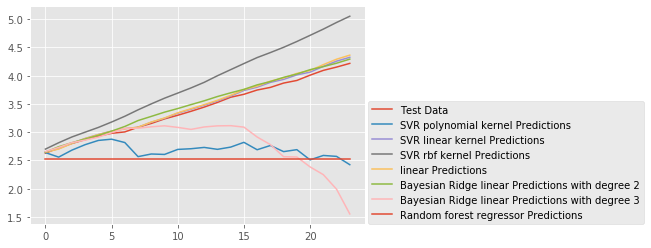

In [92]:
plt.plot(y_test)
plt.plot(svm_poly_test_pred)
plt.plot(svm_linear_test_pred)
plt.plot(svm_rbf_test_pred)
plt.plot(test_linear_pred)
plt.plot(test_bayesian_pred2)
plt.plot(test_bayesian_pred3)
plt.plot(test_rf_pred)
plt.legend(['Test Data','SVR polynomial kernel Predictions', 'SVR linear kernel Predictions', 'SVR rbf kernel Predictions', 
            'linear Predictions','Bayesian Ridge linear Predictions with degree 2',
            'Bayesian Ridge linear Predictions with degree 3','Random forest regressor Predictions'],loc=(1.01,0))
